<a href="https://colab.research.google.com/github/albalopezdevesa/HackForGood2024/blob/main/Clustering_Burnout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de la base de datos

In [ ]:
# Instala las bibliotecas necesarias
!pip install scikit-learn pandas category_encoders

Se importan librerías y archivos a emplear.

In [ ]:
from google.colab import files
import openpyxl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import pdist

# Cargar el archivo Excel desde tu sistema local
uploaded = files.upload()

Saving archivo_modificado.xlsx to archivo_modificado (1).xlsx


Se cargan los resultados de las encuestas y se guardan en la variable df

In [ ]:
# Lee el archivo Excel
df = pd.read_excel('archivo_modificado.xlsx')

# Muestra las primeras filas del DataFrame
print(df.head())

  Estudiante.42     Motivacion Eleccion.estudios Gustar.estudios  \
0            No             No                Si              No   
1            No      Si, mucho                Si              Si   
2            No             No                Si              Si   
3            Si      Si, mucho                Si              Si   
4            Si  Sí, pero poco                Si              Si   

  Aprovechar.tiempo Organizacion Comodo.compañeros  Horas.sueño  \
0                Si    Si, mucho                Si            6   
1                Si    Si, mucho                Si            3   
2                No     No, nada                Si            7   
3                Si  Si, un poco                Si            6   
4                Si  Si, un poco                Si            8   

  Dormir.suficiente Comidias.diarias Bebidas.energéticas Actividad.fisica  \
0                No         Mas de 3                Nada          5 o mas   
1                No       Menos de

# Preprocesamiento de los datos

Se pasan a categórico las variables temporales de estudio y sueño para la comodidad del análisis.

Las horas de sueño se dividirán en los intervalos [0,6) $\cup$ [6,8] $\cup$ (8,24]

El tiempo de estudio se dividirá en los intervalos [0,2) $\cup$ [2,4] $\cup$ (4,24]

In [ ]:
# Definir los límites y etiquetas para las categorías
limites = [-float('inf'), 6, 8, float('inf')]
etiquetas = ['menos de 7', '6 o 8', 'más de 8']

# Crear la columna categórica utilizando pd.cut()
df['Horas.sueño'] = pd.cut(df['Horas.sueño'], bins=limites, labels=etiquetas, include_lowest=True)

# Definir los límites y etiquetas para las categorías
limites = [-float('inf'), 2, 4, float('inf')]
etiquetas = ['menos de 1', '2 o 4', 'más de 3']

# Crear la columna categórica utilizando pd.cut()
df['Tiempo.estudios'] = pd.cut(df['Tiempo.estudios'], bins=limites, labels=etiquetas, include_lowest=True)

Al ser el objetivo del estudio identificar el síndrome de Burnout, nuestra variable objetivo a estudiar será la percepción propia de las personas acerca de su situación actual. Además, de forma adicional, se estudia cómo puede llegar a afectar la metodología de 42 con respecto a las universidades convencionales. Por este motivo, ambas variables son ignoradas a la hora de realizar la agrupación de los estudiantes en base a sus características.

In [ ]:
# Lista de columnas a mantener
columnas_a_mantener = [col for col in df.columns if col not in ['Estudiante.42', 'Burnout']]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_util = df[columnas_a_mantener]
print(df_util.head())

num = 4

      Motivacion Eleccion.estudios Gustar.estudios Aprovechar.tiempo  \
0             No                Si              No                Si   
1      Si, mucho                Si              Si                Si   
2             No                Si              Si                No   
3      Si, mucho                Si              Si                Si   
4  Sí, pero poco                Si              Si                Si   

  Organizacion Comodo.compañeros Horas.sueño Dormir.suficiente  \
0    Si, mucho                Si  menos de 7                No   
1    Si, mucho                Si  menos de 7                No   
2     No, nada                Si       6 o 8                Si   
3  Si, un poco                Si  menos de 7                Si   
4  Si, un poco                Si       6 o 8                Si   

  Comidias.diarias Bebidas.energéticas Actividad.fisica Tiempo.estudios  \
0         Mas de 3                Nada          5 o mas        más de 3   
1       Menos de 3  

# Clusterización

Como método de clusterización se emplea el algoritmo de agrupamiento linkage, el cual es un método de análisis de agrupamiento jerárquico que calcula la distancia entre los grupos cercanos para la obtención de los clusters finales.

Al tratarse por completo de un análisis sobre variables categóricas, la distancia a emplear es la distancia de Hamming, la cual consiste en lo siguiente:

La distancia de Hamming entre dos cadenas de igual longitud es la cantidad de posiciones en las que los símbolos correspondientes son diferentes. La fórmula para la distancia de Hamming se expresa como:

$$
d_H(x, y) = \sum_{i=1}^{n} \delta(x_i, y_i)
$$

Donde:
- \(d_H(x, y)\) representa la distancia de Hamming entre las cadenas \(x\) e \(y\).
- \(n\) es la longitud de las cadenas.
- \(x_i\) y \(y_i\) son los símbolos en la posición \(i\) de las cadenas \(x\) e \(y\) respectivamente.
- \(\delta(x_i, y_i)\) es la función delta de Kronecker, que devuelve 1 si \(x_i\) es diferente de \(y_i\), y 0 en caso contrario.

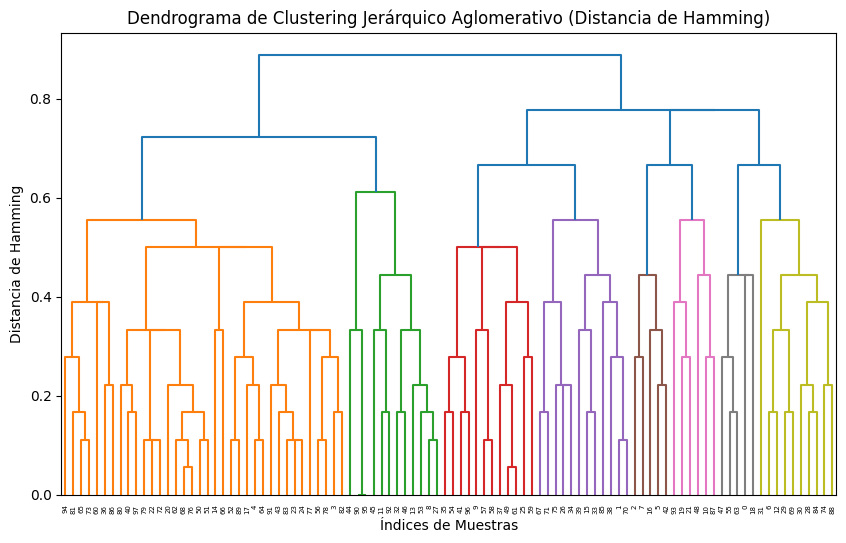

In [ ]:
# Suponiendo que tienes un DataFrame llamado 'df_util' con variables categóricas 'cat_var1', 'cat_var2', etc.
column_names = df_util.columns.tolist()

# Codifica las variables categóricas utilizando la codificación ordinal de category_encoders
encoder = ce.OrdinalEncoder(cols=column_names)
encoded_data = encoder.fit_transform(df_util)

# Calcula la matriz de distancias utilizando la distancia de Hamming
hamming_distances = pdist(encoded_data, metric='hamming')

# Calcula la matriz de enlace utilizando el método de enlace completo (complete linkage)
Z = linkage(hamming_distances, method='complete')

# Grafica el dendrograma para visualizar la jerarquía de clusters
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df_util.index)
plt.title('Dendrograma de Clustering Jerárquico Aglomerativo (Distancia de Hamming)')
plt.xlabel('Índices de Muestras')
plt.ylabel('Distancia de Hamming')
plt.show()

Este gráfico es un dendrograma, el cual muestra el orden de formación de los diferentes clústeres. Gracias a esta herramienta, se puede establecer el número de clústeres necesarios para el análisis. A primera vista, se determina que como inicio el número de clústeres a analizar es de 4, buscando obtener una mayor representatividad y la existencia de una diversidad entre los grupos en el menor número de clusters posibles.

In [ ]:
num_clusters = num
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Añade las etiquetas de los clústeres al DataFrame original
df['cluster_label'] = cluster_labels

# Muestra los resultados
print(df.head())

  Estudiante.42     Motivacion Eleccion.estudios Gustar.estudios  \
0            No             No                Si              No   
1            No      Si, mucho                Si              Si   
2            No             No                Si              Si   
3            Si      Si, mucho                Si              Si   
4            Si  Sí, pero poco                Si              Si   

  Aprovechar.tiempo Organizacion Comodo.compañeros Horas.sueño  \
0                Si    Si, mucho                Si  menos de 7   
1                Si    Si, mucho                Si  menos de 7   
2                No     No, nada                Si       6 o 8   
3                Si  Si, un poco                Si  menos de 7   
4                Si  Si, un poco                Si       6 o 8   

  Dormir.suficiente Comidias.diarias  ... Actividad.fisica Tiempo.estudios  \
0                No         Mas de 3  ...          5 o mas        más de 3   
1                No       Menos de 3  

Tras crear los clústeres de acuerdo a las variables de análisis, nos centraremos inicialmente en estudiar si son útiles para clasificar la sensación del síndrome de burnout. Para ello, se recogerá el número de individuos por clúster, así como el porcentaje de ellos que opinan padecer el síndrome.

In [ ]:
for i in range(num):
  aux1 = df[df['cluster_label'] == i+1]['Burnout']
  aux2 = round(aux1.value_counts().get('Si', 0)/len(aux1), 2)*100
  print('Cluster {}\n\tNº Elementos: {}\n\tSí bornout: {:.0f}%'.format(i+1, len(aux1), aux2))

Cluster 1
	Nº Elementos: 48
	Sí bornout: 17%
Cluster 2
	Nº Elementos: 24
	Sí bornout: 21%
Cluster 3
	Nº Elementos: 11
	Sí bornout: 82%
Cluster 4
	Nº Elementos: 15
	Sí bornout: 47%


Los cuatro clústeres obtenidos nos proporcionan una gran información en lo que respecta al síndrome de burnout. Los clústeres 1 y 2 tienen un índice bajo de padecencia, lo cual nos indica que estos clústeres poseerán ciertas características positivas a la hora de prevenir el síndrome de burnout. Como contraparte, el clúster 3 representa en gran medida a aquellos estudiantes que consideran estar quemados, y por ello poseerán las características más negativas. En un punto intermedio se encuentra el clúster 4, en el cual la mitad de los alumnos afirman sufrir el síndrome. Este grupo está formado por aquellas personas que, en un punto medio, poseen características significativas para padecer el síndrome pero no en gran medida.

In [ ]:
column_labels = df.columns.tolist()[:-1]

**Análisis cluster 1**

In [ ]:
df_cluster1 = df[df['cluster_label'] == 1]

df_conclusiones1 = pd.DataFrame([], columns=['Nombres', 'Porcentajes'])

nombres = []
porcentajes = []

for i in column_labels:
  aux1 = df_cluster1[i].value_counts()
  nombres.append(aux1.idxmax())
  porcentajes.append(aux1.max()/len(df_cluster1)*100)

df_conclusiones1['Nombres'] = nombres
df_conclusiones1['Porcentajes'] = porcentajes

nuevos_indices = {i: label for i, label in enumerate(column_labels)}
df_conclusiones1 = df_conclusiones1.rename(index=nuevos_indices)

df_conclusiones1[df_conclusiones1['Porcentajes']>=70].sort_values(by='Porcentajes', ascending=False)

,Nombres,Porcentajes
Gustar.estudios,Si,100.000000
Motivacion,"Si, mucho",95.833333
Comodo.compañeros,Si,95.833333
Eleccion.estudios,Si,93.750000
Aprovechar.tiempo,Si,91.666667
Dormir.suficiente,Si,89.583333
Autonomía,Si,89.583333
Metodología,Si,83.333333
Acompañado,Si,83.333333
Burnout,No,83.333333


Estos alumnos son aquellos que se sienten felices en su situación actual. Les gusta lo que hacen y están motivados, sienten que son efectivos con su tiempo y que tienen unos buenos niveles de salud tanto a nivel de sueño como social en relación a sus compañeros y al acompañamiento. Estas personas, de acuerdo a los análisis de las causas del síndrome de Burnout, no son propensas a padecer el síndrome, siendo así los resultados obtenidos buenos, ya que es el clúster con menor porcentaje esperado.

**Análisis cluster 2**

In [ ]:
df_cluster2 = df[df['cluster_label'] == 2]

df_conclusiones2 = pd.DataFrame([], columns=['Nombres', 'Porcentajes'])

nombres = []
porcentajes = []

for i in column_labels:
  aux1 = df_cluster2[i].value_counts()
  nombres.append(aux1.idxmax())
  porcentajes.append(aux1.max()/len(df_cluster2)*100)

df_conclusiones2['Nombres'] = nombres
df_conclusiones2['Porcentajes'] = porcentajes

nuevos_indices = {i: label for i, label in enumerate(column_labels)}
df_conclusiones2 = df_conclusiones2.rename(index=nuevos_indices)

df_conclusiones2[df_conclusiones2['Porcentajes']>=70].sort_values(by='Porcentajes', ascending=False)

,Nombres,Porcentajes
Gustar.estudios,Si,100.000000
Eleccion.estudios,Si,95.833333
Comodo.compañeros,Si,95.833333
Horas.sueño,menos de 7,91.666667
Dormir.suficiente,No,91.666667
Metodología,Si,87.500000
Autonomía,Si,87.500000
Burnout,No,79.166667
Acompañado,Si,75.000000
Comodo.competicion,Si,70.833333


Muchas de las características del clúster 2 son muy comunes a las del clúster 1. Comodidad con las personas, el ambiente y el sistema, están contentos con la situación actual. La principal diferencia, que es lo que los divide en otro grupo, son las horas de sueño. Este grupo duerme mayoritariamente poco, y además así lo consideran a nivel personal. Esta es una característica que tiene su importancia a la hora de padecer el síndrome, siendo el descanso diario esencial para evitar excesos y colapsos. Así, de la forma esperada, se tiene que el porcentaje de sensación es mayor en el clúster 2 que en el clúster 1, siendo la principal diferencia el sueño.

**Análisis cluster 3**

In [ ]:
df_cluster3 = df[df['cluster_label'] == 3]

df_conclusiones3 = pd.DataFrame([], columns=['Nombres', 'Porcentajes'])

nombres = []
porcentajes = []

for i in column_labels:
  aux1 = df_cluster3[i].value_counts()
  nombres.append(aux1.idxmax())
  porcentajes.append(aux1.max()/len(df_cluster3)*100)

df_conclusiones3['Nombres'] = nombres
df_conclusiones3['Porcentajes'] = porcentajes

nuevos_indices = {i: label for i, label in enumerate(column_labels)}
df_conclusiones3 = df_conclusiones3.rename(index=nuevos_indices)

df_conclusiones3[df_conclusiones3['Porcentajes']>=70].sort_values(by='Porcentajes', ascending=False)

,Nombres,Porcentajes
Aprovechar.tiempo,No,100.000000
Gustar.estudios,Si,90.909091
Autonomía,Si,90.909091
Acompañado,No,81.818182
Presion.tareas,Si,81.818182
Burnout,Si,81.818182
Estudiante.42,No,72.727273
Motivacion,"Sí, pero poco",72.727273
Metodología,No,72.727273
Ambiente.competitivo,Si,72.727273


Este clúster refleja de manera muy efectiva las causas del síndrome de burnout. Son personas con unas altas expectativas que tienen gusto por sus estudios, pero que no se sienten motivadas. La metodología usada no la consideran adecuada y sienten una falta de acompañamiento. Esto acaba provocando que sientan que están perdiendo el tiempo y una gran decepción ante las expectativas, siendo causas muy fuertes en la aparición del síndrome.

**Analisis cluster 4**

In [ ]:
df_cluster4 = df[df['cluster_label'] == 4]

df_conclusiones4 = pd.DataFrame([], columns=['Nombres', 'Porcentajes'])

nombres = []
porcentajes = []

for i in column_labels:
  aux1 = df_cluster4[i].value_counts()
  nombres.append(aux1.idxmax())
  porcentajes.append(aux1.max()/len(df_cluster4)*100)

df_conclusiones4['Nombres'] = nombres
df_conclusiones4['Porcentajes'] = porcentajes

nuevos_indices = {i: label for i, label in enumerate(column_labels)}
df_conclusiones4 = df_conclusiones4.rename(index=nuevos_indices)

df_conclusiones4[df_conclusiones4['Porcentajes']>=70].sort_values(by='Porcentajes', ascending=False)

,Nombres,Porcentajes
Eleccion.estudios,Si,100.000000
Comodo.compañeros,Si,100.000000
Gustar.estudios,Si,86.666667
Dormir.suficiente,No,86.666667
Acompañado,Si,80.000000
Comodo.competicion,Si,80.000000
Autonomía,Si,80.000000
Presion.tareas,Si,80.000000
Estudiante.42,No,73.333333
Comidias.diarias,Mas de 3,73.333333


Este clúster tiene un gran parecido con el clúster 2. Los atributos que más aparecen concuerdan entre ambos clústeres, las diferencias radican en la cantidad. El clúster 2 es menos diverso en aquellas variables beneficiosas para la prevención del síndrome, lo que hace que sea un grupo más sano. Por el contrario, el clúster 4, al tener una diversidad mayor, posee un mayor malestar, llegando a tener un porcentaje mucho más elevado de sentimiento de padecimiento.

# Analisis variables

En base a los patrones obtenidos a partir de los clústeres y del conocimiento de las causas del síndrome de burnout, se extrae el siguiente análisis de las variables.

**Variables sin importancia:**

Estas variables son aquellas que aparecen de manera repetitiva en todos y cada uno de los clústeres, siempre con el mismo atributo dominante, lo cual nos indica que no es un valor a tener en cuenta para la diferenciación o que la muestra poblacional obtenida está sesgada. Estas variables serán ignoradas para la predicción.
* Gusto por estudios
* Autonomía
* Elección de estudios

**Variables buenas para evitar burnout:**
Estas variables son aquellas comunes entre los grupos 1 y 2 y que difieren de las variables sin importancia. Estas variables están asociadas al bienestar personal y a prevenir el síndrome de burnout. Además, estas variables son aquellas que en el clúster 4 se ven disminuidas y provocan un aumento en el malestar de la persona.
* Comodo con compañeros - Si
* Metodología - Si

**Variables malas (provocan) burnout:**
Estas variables son aquellas que, en primer lugar, son las más populares dentro del clúster 3, el cual claramente hace referencia a las causas del síndrome de burnout. Además, algunas de estas características también se encuentran en el clúster 4, que es el segundo más afectado.
* Presión tareas - Si
* Acompañado - No
* Aprovechar el tiempo - No

# Regresión para la diferenciacion de clusteres

A continuación, se va a realizar una regresión que busca predecir el clúster al que pertenece un individuo a partir de las características de la persona. El objetivo de este estudio es determinar cuáles son las variables que tienen más importancia o peso a la hora de seleccionar a qué clúster pertenece un individuo.

Para ello se tomará un 80% de los datos para el entrenamiento de la regresión y un 20% para el testeo, con el fin de confirmar la adecuación de la regresión.

In [ ]:
# Supongamos que tienes tus datos en un DataFrame llamado df
df_regresion = df.drop(columns=['Gustar.estudios', 'Autonomía', 'Eleccion.estudios', 'Burnout'])

# Dividir los datos en características (X) y la variable objetivo (y)
X = df_regresion.drop('cluster_label', axis=1)
y = df_regresion['cluster_label'] - 1  # Restar 1 para que las etiquetas comiencen desde 0

# Codificar las variables categóricas
X_encoded = X.apply(LabelEncoder().fit_transform)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=8)

# Configurar el clasificador XGBoost
model = xgb.XGBClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9


El modelo tiene una precisión del 90% de acierto sobre los datos de entrenamiento, lo que lo convierte en un buen modelo para predecir el clúster al que se pertenece.

Para el análisis de las variables, se verá qué peso (porcentaje) tiene cada variable a la hora de determinar el valor del clúster en la regresión.

In [ ]:
# Crear un DataFrame con los nombres de las características y su importancia
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar el DataFrame
print(feature_importance_df)

                 Feature  Importance
2      Aprovechar.tiempo    0.167105
6      Dormir.suficiente    0.139325
4      Comodo.compañeros    0.095481
5            Horas.sueño    0.085097
1             Motivacion    0.065372
7       Comidias.diarias    0.060492
12            Acompañado    0.060109
8    Bebidas.energéticas    0.057703
0          Estudiante.42    0.056706
11           Metodología    0.053153
10       Tiempo.estudios    0.049047
9       Actividad.fisica    0.041889
13  Ambiente.competitivo    0.023491
3           Organizacion    0.018919
14    Comodo.competicion    0.014933
15        Presion.tareas    0.011180


Se tiene que los dos valores más significativos son si se siente que se pierde el tiempo o si se ha dormido lo suficiente. Estos factores están estrechamente ligados con las causas del síndrome, siendo al final el sentimiento de la pérdida de tiempo una expresión del desánimo, y el tiempo de descanso, el cual es vital para el bienestar de la persona.

Por otro lado, aunque con algo menos de importancia, se tienen la comodidad con los compañeros y las horas de sueño. Las horas de sueño están totalmente correlacionadas con el considerar si se duerme suficiente, mientras que el contacto social y la comodidad son constantes y necesarias en la vida humana para su desarrollo y felicidad.

# Regresión para la clasificación del sindrome

Para confirmar la adecuación de las conclusiones obtenidas, es necesario evaluar el método de clúster. Para ello, se va a realizar una regresión para predecir el síndrome, considerando el clúster al que se pertenece. El objetivo es obtener un modelo que sea efectivo y en el que la variable clúster sea importante.

Para la metodología se aplicará el mismo sistema que en el caso anterior: un 80% de entrenamiento y un 20% de testeo.

In [ ]:
# Supongamos que tienes tus datos en un DataFrame llamado df
df_regresion = df.drop(columns=['Gustar.estudios', 'Autonomía', 'Eleccion.estudios'])

# Dividir los datos en características (X) y la variable objetivo (y)
X = df_regresion.drop('Burnout', axis=1)
y = df_regresion['Burnout']

# Crear un objeto LabelEncoder y ajustarlo a las etiquetas de clase
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Codificar las variables categóricas en las características
X_encoded = X.apply(LabelEncoder().fit_transform)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=7)

# Configurar el clasificador XGBoost
model = xgb.XGBClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8


El modelo obtenido predice correctamente el 80% de los datos de test, por lo que se considera un modelo adecuado para la predicción del sentimiento de padecer el síndrome de burnout. A continuación, procederemos a analizar la importancia de las variables en el modelo.

In [ ]:
# Crear un DataFrame con los nombres de las características y su importancia
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar el DataFrame
print(feature_importance_df)

                 Feature  Importance
16         cluster_label    0.143195
1             Motivacion    0.095300
0          Estudiante.42    0.091701
15        Presion.tareas    0.073922
3           Organizacion    0.072577
7       Comidias.diarias    0.068843
12            Acompañado    0.066791
11           Metodología    0.053454
10       Tiempo.estudios    0.053176
2      Aprovechar.tiempo    0.052691
5            Horas.sueño    0.048756
14    Comodo.competicion    0.047809
8    Bebidas.energéticas    0.037848
9       Actividad.fisica    0.037732
6      Dormir.suficiente    0.030438
13  Ambiente.competitivo    0.025768
4      Comodo.compañeros    0.000000


La variable más importante en esta predicción es el cluster_label, con un nivel significativamente mayor al resto. Esto nos indica que es la variable más relacionada con el síndrome y que se pueden sacar conclusiones validas a partir de la agrupación.

#Análisis metodología universitaria clasica y de 42

Como análisis secundario, se tiene la comparación entre el método universitario convencional y el método pair to pair de 42. El enfoque de esta comparación será determinar si alguna de las metodologías favorece a sus estudiantes para evitar padecer del síndrome de burnout.

Para ello se van a analizar los porcentajes de personas universitarias y de 42 acerca de su opinión sobre si padecen el síndrome. Cada clúster ha sido validado como correcto, por lo que se espera un análisis adecuado.

**Base de datos total**

In [ ]:
df_42 = df[df['Estudiante.42'] == 'Si']
print('Estudiantes 42 con Burnout --> {:.0f}%'.format(len(df_42[df_42['Burnout'] == 'Si'])/len(df_42)*100))
df_uni = df[df['Estudiante.42'] == 'No']
print('Estudiantes universitarios con Burnout --> {:.0f}%'.format(len(df_uni[df_uni['Burnout'] == 'Si'])/len(df_uni)*100))

Estudiantes 42 con Burnout --> 23%
Estudiantes universitarios con Burnout --> 38%


**Cluster 1**

In [ ]:
df_42 = df_cluster1[df_cluster1['Estudiante.42'] == 'Si']
print('Estudiantes 42 con Burnout --> {:.0f}%'.format(len(df_42[df_42['Burnout'] == 'Si'])/len(df_42)*100))
df_uni = df_cluster1[df_cluster1['Estudiante.42'] == 'No']
print('Estudiantes universitarios con Burnout --> {:.0f}%'.format(len(df_uni[df_uni['Burnout'] == 'Si'])/len(df_uni)*100))

Estudiantes 42 con Burnout --> 19%
Estudiantes universitarios con Burnout --> 12%


**Cluster 2**

In [ ]:
df_42 = df_cluster2[df_cluster2['Estudiante.42'] == 'Si']
print('Estudiantes 42 con Burnout --> {:.0f}%'.format(len(df_42[df_42['Burnout'] == 'Si'])/len(df_42)*100))
df_uni = df_cluster2[df_cluster2['Estudiante.42'] == 'No']
print('Estudiantes universitarios con Burnout --> {:.0f}%'.format(len(df_uni[df_uni['Burnout'] == 'Si'])/len(df_uni)*100))

Estudiantes 42 con Burnout --> 14%
Estudiantes universitarios con Burnout --> 30%


**Cluster 3**

In [ ]:
df_42 = df_cluster3[df_cluster3['Estudiante.42'] == 'Si']
print('Estudiantes 42 con Burnout --> {:.0f}%'.format(len(df_42[df_42['Burnout'] == 'Si'])/len(df_42)*100))
df_uni = df_cluster3[df_cluster3['Estudiante.42'] == 'No']
print('Estudiantes universitarios con Burnout --> {:.0f}%'.format(len(df_uni[df_uni['Burnout'] == 'Si'])/len(df_uni)*100))

Estudiantes 42 con Burnout --> 67%
Estudiantes universitarios con Burnout --> 88%


**Cluster 4**

In [ ]:
df_42 = df_cluster4[df_cluster4['Estudiante.42'] == 'Si']
print('Estudiantes 42 con Burnout --> {:.0f}%'.format(len(df_42[df_42['Burnout'] == 'Si'])/len(df_42)*100))
df_uni = df_cluster4[df_cluster4['Estudiante.42'] == 'No']
print('Estudiantes universitarios con Burnout --> {:.0f}%'.format(len(df_uni[df_uni['Burnout'] == 'Si'])/len(df_uni)*100))

Estudiantes 42 con Burnout --> 50%
Estudiantes universitarios con Burnout --> 45%


De esta forma, se observa que hay cierto equilibrio entre ambas metodologías. Dependiendo del clúster en el que se esté, hay un porcentaje más alto en uno u otro subgrupo, por lo que se descarta el hecho de que la metodología sea un parámetro clave. Sin embargo, sí se observa una ligera influencia. Si se analiza de manera más profunda, se observa que en el formato general de 42 hay un 15% menos de burnout que en las universidades. Estos datos también se reflejan en los clústeres, ya que cuando 42 tiene un mayor índice, este es pequeño, menor del 10%. En cambio, cuando las universidades tienen un índice mayor, este es mucho mayor que en 42, como se puede ver en el clúster 3, con una diferencia del 21%.

De esta manera, se tiene que la metodología de 42 afecta de manera positiva para evitar el síndrome de burnout, aunque no de manera significativa. Los estudiantes en 42 suelen estar más contentos con el ambiente, su salud personal y su ánimo, lo cual incide un menor riesgo de padecer el síndrome de burnout.